In [17]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import shutil

from keras.applications import MobileNet
from keras.models import Model
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout

In [18]:
# DIRECTORIES
PATH = ''
path_cad_generated = PATH + "data/cad_generated/"
path_cad_pics = PATH + "data/cad_pictures/"
path_models = PATH + 'models/'
path_bad = PATH + "data/real_pictures/Bad/"
path_real_pics = PATH + "data/real_pictures/All/"
path_features = PATH + "data/features/"

# Create Directories
def create_dir(path):
    shutil.rmtree(path)
    os.makedirs(path)

create_dir(path_features)

In [19]:
# PARAMETERS
img_width, img_height = 224, 224
EPOCHS = 200
BATCH_SIZE = 16

In [20]:
# load mobilenet model
mobilenet = MobileNet(weights='imagenet', include_top=False,
                       input_shape=(img_width, img_height, 3))

In [21]:
def load_and_extract_features(path_image, img_width, img_height):
    image = cv2.imread(path_image, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (img_width, img_height))
    features = mobilenet.predict(image.reshape(1, img_width, img_height, 3))
    return features

In [22]:
# Use Mobilenet without its top layers to extract features from generated and real images
train_data = []
train_labels = []
val_data = []
val_labels = []
# Iterate through all real images to extract features and add them to the data array
for real_img_name in os.listdir(path_real_pics):
    # Load and resize real images
    real_img = cv2.imread(path_real_pics + real_img_name, cv2.IMREAD_COLOR)
    real_img = cv2.resize(real_img, (img_width, img_height))
    # Apply mobilenet without top layers to extract features from the image
    real_feat = mobilenet.predict(real_img.reshape(1, img_width, img_height, 3))

  # iterate through all generated images to find the corresponding one
    for gen_img_name in os.listdir(path_cad_generated):
        if gen_img_name[:-4] in real_img_name:
            # Load and resize generated images
            gen_img = cv2.imread(path_cad_generated + gen_img_name, cv2.IMREAD_COLOR)
            gen_img = cv2.resize(gen_img, (img_width, img_height))
            # Apply mobilenet without top layers to extract features from the image
            gen_feat = mobilenet.predict(real_img.reshape(1, img_width, img_height, 3))
      
    # concatenate features extracted from real and generated images
    feat_arr = np.concatenate((real_feat, gen_feat), axis=1)
    feat_arr = feat_arr[:, :, :, :-1].reshape((341, -1, 3))

    # collect the features into training and validation arrays with their class (bad or good)
    if "1" in real_img_name:
        val_data.append(feat_arr)
        val_labels.append([0, 1] if "bad" in real_img_name else [1, 0])
    else:
        train_data.append(feat_arr)
        train_labels.append([0, 1] if "bad" in real_img_name else [1, 0])

train_data, val_data = np.asarray(train_data), np.asarray(val_data) 
train_labels, val_labels = np.asarray(train_labels), np.asarray(val_labels) 
print(train_data.shape, train_labels.shape, val_data.shape, val_labels.shape)

(112, 341, 98, 3) (112, 2) (44, 341, 98, 3) (44, 2)


In [27]:
# Define Convolutional model
convolutional = Sequential()
convolutional.add(Flatten())
convolutional.add(Dense(1024, activation='relu'))
convolutional.add(Dropout(0.5))
convolutional.add(Dense(64, activation='relu'))
convolutional.add(Dropout(0.5))
convolutional.add(Dense(2, activation='softmax'))

# Train Convolutional Model
convolutional.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])

history = convolutional.fit(train_data, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

# Save Trained Model


Epoch 1/200
1/6 [====>.........................] - ETA: 0s - loss: 2.8666 - accuracy: 0.3125

KeyboardInterrupt: 

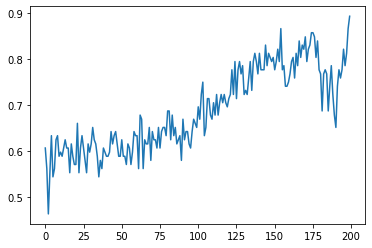

In [24]:
plt.plot(history.history['accuracy'])

In [25]:
score = convolutional.evaluate(val_data, val_labels, batch_size=8)

6/6 [==============================] - 0s 45ms/step - loss: 0.8166 - accuracy: 0.7955


In [26]:
# Save convolutional model to JSON format
# serialize model to JSON
model_json = convolutional.to_json()
with open(path_models + 'convolutional.json', "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
convolutional.save_weights(path_models + "convolutional_weights.h5")
print("Saved convolutional model to disk")

Saved convolutional model to disk
